In [1]:
import torch
import pathlib
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
%matplotlib inline

from passion.segmentation import prediction

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Load testing models

In [3]:
models_folder_path = pathlib.Path('../../workflow/output/model')
old_rooftop_models_folder_path = models_folder_path / 'old-rooftop-segmentation'
rooftop_models_folder_path = models_folder_path / 'rooftop-segmentation'
section_models_folder_path = models_folder_path / 'section-segmentation'

# Sections models
model_mix_val19 = torch.load(str(old_rooftop_models_folder_path / 'segments-mix-val19.pth'), map_location=torch.device(device))
model_mix_val20 = torch.load(str(old_rooftop_models_folder_path / 'segments-mix-val20.pth'), map_location=torch.device(device))
model_z19 = torch.load(str(old_rooftop_models_folder_path / 'segments-z19.pth'), map_location=torch.device(device))
model_z19_aug = torch.load(str(old_rooftop_models_folder_path / 'segments-z19-aug.pth'), map_location=torch.device(device))
model_z20 = torch.load(str(old_rooftop_models_folder_path / 'segments-z20.pth'), map_location=torch.device(device))
model_z20_aug = torch.load(str(old_rooftop_models_folder_path / 'segments-z20-aug.pth'), map_location=torch.device(device))

model_final_15e = torch.load(str(section_models_folder_path / 'sections-mix-aug-15e.pth'), map_location=torch.device(device))
model_final_20e = torch.load(str(section_models_folder_path / 'sections-mix-aug-20e.pth'), map_location=torch.device(device))

# Rooftop models
model_inria_aug_10e = torch.load(str(old_rooftop_models_folder_path / 'inria-aug-10e.pth'), map_location=torch.device(device))
model_inria_aug_5e = torch.load(str(old_rooftop_models_folder_path / 'inria-aug-5e.pth'), map_location=torch.device(device))
model_inria_raw_10e = torch.load(str(old_rooftop_models_folder_path / 'inria-raw-10e.pth'), map_location=torch.device(device))
model_inria_raw_5e = torch.load(str(old_rooftop_models_folder_path / 'inria-raw-5e.pth'), map_location=torch.device(device))

model_inria_final = torch.load(str(rooftop_models_folder_path / 'inria-aug-12e.pth'), map_location=torch.device(device))

# Testing folder paths

In [4]:
rid_test_folder = pathlib.Path('/storage/internal/home/r-pueblas/projects/rooftop-segmentation-datasets/data/RID/output/masks_segments_reviewed/test')
rid_test_folder_image = rid_test_folder / 'image'
rid_test_folder_label = rid_test_folder / 'label'

# Metrics

In [5]:
def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label

def angle_difference(angle_1, angle_2):
    a = angle_1 - angle_2
    a = (a + 180) % 360 - 180
    return a

def mean_angle_difference(pred_label, label, num_classes, angles, background_class, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]
    
    combined_pred_label = (pred_label != background_class).astype('uint8')
    combined_label = (label != background_class).astype('uint8')
    
    # Take those pixels where both images predict a class different than background
    pred_label_angles = pred_label[combined_pred_label == combined_label]
    pred_label_angles = pred_label_angles[pred_label_angles < len(angles)]
    label_angles = label[combined_pred_label == combined_label]
    label_angles = label_angles[label_angles < len(angles)]
    
    
    total_diff = 0
    for angle_1, angle_2 in zip(np.nditer(pred_label_angles, flags=['zerosize_ok']), np.nditer(label_angles, flags=['zerosize_ok'])):
        try:
            angle_1, angle_2 = angles[angle_1], angles[angle_2]
        except:
            print(angle_1, angle_2)
        diff = angle_difference(angle_1, angle_2)
        total_diff = total_diff + diff
    
    if pred_label_angles.size == 0:
        return None
    
    mean_diff = total_diff/pred_label_angles.size
    
    return mean_diff

# Helper functions

In [6]:
def test_model_sections(model, test_folder, num_classes, background_class, ignore_index, num_angles, output=True):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    angles = [i * (360/num_angles) for i in range(num_angles)]

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)
    total_angle_difference = 0

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]


        pred = prediction.segment_img(image, model, tile_size=512, stride=512, background_class=background_class)
        corrected_pred = pred.copy()
        corrected_pred[pred==0] = (background_class + 1)
        corrected_pred = (corrected_pred - 1)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(corrected_pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        mad = mean_angle_difference(corrected_pred, label, num_classes, angles, background_class, ignore_index)
        if mad: total_angle_difference += mad

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(corrected_pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('model_mix_aug')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}, mean angle difference: {mad}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union
    mad = total_angle_difference / (i+1)

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
        print(f'Final mean angle difference: {mad}')

    return iou, np.mean(iou[~np.isnan(iou)]), mad, elapsed_time

def test_model_twolook(rooftop_model,
                       sections_model,
                       test_folder,
                       num_classes,
                       background_class_1,
                       background_class_2,
                       ignore_index,
                       num_angles,
                       output=True
                      ):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    angles = [i * (360/num_angles) for i in range(num_angles)]

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)
    total_angle_difference = 0

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]
    
        roofs = prediction.segment_img(image, rooftop_model, tile_size=512, stride=512, background_class=background_class_1)
        filtered = np.ones(image.shape).astype(np.uint8)
        idx=(roofs!=0)
        filtered[idx] = image[idx]

        pred = prediction.segment_img(image, sections_model, tile_size=512, stride=512, background_class=background_class_2)
        pred = (pred * idx.astype('uint8'))
        corrected_pred = pred.copy()
        corrected_pred[pred==0] = (background_class + 1)
        corrected_pred = (corrected_pred - 1)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(corrected_pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        mad = mean_angle_difference(corrected_pred, label, num_classes, angles, background_class, ignore_index)
        if mad: total_angle_difference += mad

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(corrected_pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('model_mix_aug')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}, mean angle difference: {mad}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union
    mad = total_angle_difference / (i+1)

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
        print(f'Final mean angle difference: {mad}')

    return iou, np.mean(iou[~np.isnan(iou)]), mad, elapsed_time

# Results

In [7]:
num_classes = 18
background_class = 17
ignore_index = -1
num_angles = 16

In [8]:
print(f'Testing model <model_mix_val19>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_mix_val19, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_mix_val19>...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.7531550469150653
Mean angle difference: -16.20632294923284 degrees
IoU per class: [0.78116735 0.76174636 0.79028055 0.80619657 0.72820372 0.52545848
 0.79072146 0.85061293 0.77119467 0.74014625 0.76397483 0.78482187
 0.68648253 0.40424874 0.78336129 0.84851556 0.77181501 0.96784266]
Elapsed time: 107.83455848693848 seconds.


In [9]:
print(f'Testing model <model_mix_val20>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_mix_val20, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_mix_val20>...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.7370236573213111
Mean angle difference: -19.23266528621342 degrees
IoU per class: [0.75137555 0.70920686 0.75579015 0.79440881 0.69300843 0.53895328
 0.7634351  0.83479137 0.75448043 0.69859614 0.74017477 0.76892078
 0.64401693 0.53240474 0.76168433 0.84211886 0.72107065 0.96198864]
Elapsed time: 108.07276153564453 seconds.


In [10]:
print(f'Testing model <model_z19>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z19, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z19>...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.29095039853222926
Mean angle difference: -34.80088528666459 degrees
IoU per class: [0.31972888 0.25757975 0.35950387 0.38204281 0.25422465 0.
 0.33697394 0.35677739 0.23408792 0.17436191 0.28232727 0.31734373
 0.15935428 0.         0.22382398 0.5144346  0.17393821 0.89060399]
Elapsed time: 103.58703684806824 seconds.


In [11]:
print(f'Testing model <model_z19_aug>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z19_aug, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z19_aug>...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.2775709675686454
Mean angle difference: -33.49447935622619 degrees
IoU per class: [0.24660646 0.20049536 0.21967683 0.39833762 0.18164558 0.07646138
 0.28118077 0.30696202 0.26478893 0.09655301 0.23620125 0.37077178
 0.27741331 0.1091352  0.2653397  0.42057707 0.13376918 0.91036197]
Elapsed time: 105.55283403396606 seconds.


In [12]:
print(f'Testing model <model_z20>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z20, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z20>...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.5991257021727997
Mean angle difference: -22.79417140563867 degrees
IoU per class: [6.70385108e-01 6.61281449e-01 6.76535406e-01 7.04346860e-01
 5.91729080e-01 5.04183359e-04 6.50657675e-01 7.84066825e-01
 7.10502856e-01 6.70045759e-01 5.48333005e-01 6.39731292e-01
 4.39837558e-01 1.55038760e-03 6.39690629e-01 8.00009124e-01
 6.39724742e-01 9.55330697e-01]
Elapsed time: 106.69056487083435 seconds.


In [13]:
print(f'Testing model <model_z20_aug>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z20_aug, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z20_aug>...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.6648623734806555
Mean angle difference: -19.35116549581229 degrees
IoU per class: [0.62784522 0.62094736 0.72869829 0.74257018 0.64615709 0.44658038
 0.71264627 0.79118717 0.67881782 0.65064636 0.65273251 0.68185944
 0.59223605 0.31503747 0.6765217  0.78625277 0.6582319  0.95855475]
Elapsed time: 111.7129328250885 seconds.


In [14]:
print(f'Testing final model 15e...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_final_15e, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing final model 15e...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.7449636786526191
Mean angle difference: -19.80071245771624 degrees
IoU per class: [0.78150966 0.73894543 0.76224772 0.77727093 0.67690572 0.56287627
 0.78497262 0.82674726 0.75354502 0.769772   0.73204784 0.75426419
 0.63378885 0.57655613 0.77422399 0.85148127 0.68616565 0.96602566]
Elapsed time: 111.2344319820404 seconds.


In [15]:
print(f'Testing final model 20e...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_final_20e, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing final model 20e...


/tmp/ipykernel_1140505/2685243659.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.7571766910976859
Mean angle difference: -18.806027078842952 degrees
IoU per class: [0.80386871 0.75151592 0.76568914 0.78167991 0.72114683 0.58731749
 0.76736326 0.82616233 0.78099505 0.7695172  0.75503133 0.75929833
 0.6352617  0.61415266 0.78648318 0.85351961 0.70210223 0.96807557]
Elapsed time: 114.07526326179504 seconds.


# Two-look

In [16]:
num_classes = 18
background_class_1 = 0
background_class_2 = 17
ignore_index = -1
num_angles = 16

In [17]:
rooftop_models = [model_inria_raw_5e, model_inria_aug_5e, model_inria_raw_10e, model_inria_aug_10e, model_inria_final]
sections_models = [model_z19, model_z19_aug, model_z20, model_z20_aug, model_mix_val19, model_mix_val20, model_final_15e, model_final_20e]

table_ious = np.zeros((len(rooftop_models), len(sections_models)))
table_mads = np.zeros((len(rooftop_models), len(sections_models)))

for i, rooftop_model in enumerate(rooftop_models):
    for j, section_model in enumerate(sections_models):
        print(f'Testing two look models {i} and {j}...')
        iou, mean_iou, mad, elapsed_time = test_model_twolook(rooftop_model,
                                                               section_model,
                                                               rid_test_folder,
                                                               num_classes,
                                                               background_class_1,
                                                               background_class_2,
                                                               ignore_index,
                                                               num_angles,
                                                               output=False)
        table_ious[i][j] = mean_iou
        table_mads[i][j] = mad
        print(f'Mean IoU: {mean_iou}')
        print(f'Mean angle difference: {mad} degrees')
        print(f'IoU per class: {iou}')
        print(f'Elapsed time: {elapsed_time} seconds.')

Testing two look models 0 and 0...


/tmp/ipykernel_1140505/2685243659.py:137: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.26696221997879727
Mean angle difference: -33.09293577423933 degrees
IoU per class: [0.30642311 0.20741646 0.28318447 0.33894485 0.24524194 0.
 0.32504005 0.33893222 0.23159731 0.15094721 0.26593196 0.26076799
 0.15564965 0.         0.19006948 0.45716616 0.17133753 0.87666958]
Elapsed time: 210.96485543251038 seconds.
Testing two look models 0 and 1...
Mean IoU: 0.25647552690459274
Mean angle difference: -32.989920048690756 degrees
IoU per class: [0.2491687  0.16562766 0.15606805 0.35742113 0.17799359 0.08129984
 0.26971295 0.28990539 0.26056528 0.08711743 0.21843739 0.31255403
 0.2693928  0.11100631 0.22090596 0.37458904 0.12291191 0.89188204]
Elapsed time: 210.51386833190918 seconds.
Testing two look models 0 and 2...
Mean IoU: 0.5206330263494122
Mean angle difference: -20.06530146589305 degrees
IoU per class: [6.46576092e-01 5.49741803e-01 4.72902963e-01 5.97125272e-01
 5.53149456e-01 4.90556782e-04 6.06738715e-01 7.02435398e-01
 6.77172331e-01 6.15486009e-01 4.40413810e-

Mean IoU: 0.6223908630622019
Mean angle difference: -17.128361629537313 degrees
IoU per class: [0.73701181 0.63463708 0.48884699 0.63971773 0.60153827 0.51792756
 0.66265898 0.69222353 0.70989643 0.67708409 0.55107957 0.56656425
 0.56654001 0.47556081 0.56814691 0.70449286 0.49253831 0.91657031]
Elapsed time: 190.94991874694824 seconds.
Testing two look models 2 and 7...
Mean IoU: 0.6299766405037781
Mean angle difference: -15.441669618148067 degrees
IoU per class: [0.75367708 0.65553548 0.48212441 0.63970711 0.64461449 0.51034665
 0.6478836  0.69640537 0.730504   0.67521945 0.549001   0.56927156
 0.56093644 0.52664975 0.57705525 0.70595159 0.4974967  0.91719959]
Elapsed time: 183.17828965187073 seconds.
Testing two look models 3 and 0...
Mean IoU: 0.26304861373064026
Mean angle difference: -33.09743230566523 degrees
IoU per class: [0.30952276 0.20101838 0.29444079 0.33982867 0.24795968 0.
 0.28729996 0.32490321 0.21936457 0.16235237 0.27567731 0.2826684
 0.15609992 0.         0.1892098

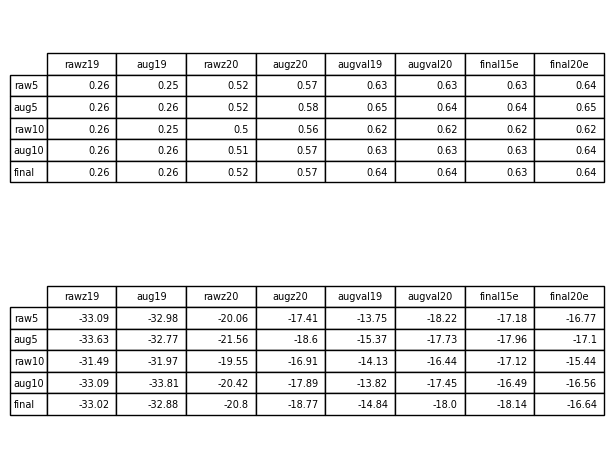

In [19]:
table_ious_rounded = (table_ious * 100).astype('int') / 100
table_mads_rounded = (table_mads * 100).astype('int') / 100
ious_df = pd.DataFrame(data=table_ious_rounded,
             index=['raw5','aug5','raw10','aug10', 'final'],
             columns=['rawz19','aug19','rawz20','augz20','augval19','augval20','final15e','final20e'])
mads_df = pd.DataFrame(data=table_mads_rounded,
             index=['raw5','aug5','raw10','aug10','final'],
             columns=['rawz19','aug19','rawz20','augz20','augval19','augval20','final15e','final20e'])

fig, ax = plt.subplots(2,1)

# hide axes
fig.patch.set_visible(False)
ax[0].axis('off'), ax[1].axis('off')
ax[0].axis('tight'), ax[1].axis('tight')

ax[0].table(cellText=ious_df.values, rowLabels=ious_df.index, colLabels=ious_df.columns, loc='center')
ax[1].table(cellText=mads_df.values, rowLabels=mads_df.index, colLabels=mads_df.columns, loc='center')

fig.tight_layout()

plt.show()